# Introduction

---



This project is an exploration of the use of **AutoML tools** to solve **time series forecasting** problems.

**Forecasting**, or predicting the future value of a variable based on time series data, benefits many real-world business sectors. Its implementation can easily be found in various areas around us, such as weather prediction, stock market forecasting, and sales prediction. However, time series modeling is complex and differs from other machine learning problems, such as classification or regression.

**AutoML** stands for automatic machine learning (ML). Generally, these tools automate tasks such as model selection and hyperparameter tuning, making these processes significantly less tedious. There are drawbacks to using AutoML, such as limited flexibility in tweaking the models. However, it is an excellent tool for prototyping and validating that the dataset is not just noise.

This project is focusing on these AutoML tools for time-series forecasting:
- [AutoTS](https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html), focusing on classical and traditional machine learning methods,
- [GCP AutoML](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/overview), cloud-based solutions.

For each AutoML tools, we can evaluate their performance, ease of use, interpretability, and robustness.

**Keywords:** time series, forecasting, automl

## Dataset

This project uses a **daily commodity price dataset** from several cities in East Java, covering the time period from January 2018 to July 2024.

The chosen commodity is **shallot**, as it is a staple ingredient and the prices can fluctuate to more than triple the average.

This project will focus on **two regions: Mojokerto and Surabaya**. These regions represent smaller city (Mojokerto) and a major consumer market (Surabaya), respectively.

The data is obtained from [SISKAPERBAPO Jatim](https://siskaperbapo.jatimprov.go.id/) website.

In [1]:
!python -m pip install numpy scipy scikit-learn seaborn statsmodels lightgbm xgboost numexpr bottleneck yfinance pytrends fredapi --exists-action i
!python -m pip install pystan prophet --exists-action i
!python -m pip install tensorflow
!python -m pip install mxnet --no-deps
!python -m pip install gluonts arch
!python -m pip install holidays-ext pmdarima dill greykite --exists-action i --no-deps
!python -m pip install autots --exists-action i
!pip install neuralprophet
!pip install pytorch torchvision torchaudio cpuonly
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.7/22.7 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.0/851.0 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.

# Exploratory Data Analysis


---




In [2]:
from google.cloud import storage

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import time
import csv
import os
import io

In [3]:
# Helper functions

def download_csv_from_gcs(bucket, file_name,
                          date_columns=None, col_names=None):
    """ A function to download dataset from GCS. """

    blob = bucket.blob(file_name)
    data = blob.download_as_text()
    df = pd.read_csv(io.StringIO(data),
                     parse_dates=date_columns,
                     usecols=col_names)
    return df

def upload_csv_to_gcs(df, bucket, file_path, sep=','):
    """ A function to upload dataset to GCS. """

    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')

    blob = bucket.blob(file_path)
    blob.upload_from_string(csv_buffer.getvalue(), content_type='text/csv')

    print(f"Successfully uploaded: '{blob.name}' to '{bucket.name}'")

In [5]:
# Create a client GCS and get the specified bucket
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)

In [6]:
prices_df = download_csv_from_gcs(bucket, PRICES_CSV, date_columns=["date"])

In [7]:
# We can take a look at the shallot price dataset, which has a daily frequency
prices_df.groupby(["data_split", "regions"]).head(2)

,date,data_split,regions,price
0,2018-01-01,TRAIN,mojokerto,14750
1,2018-01-02,TRAIN,mojokerto,14750
2374,2024-07-02,VALIDATE,mojokerto,26500
2375,2024-07-03,VALIDATE,mojokerto,24250
2389,2024-07-17,TEST,mojokerto,22412
2390,2024-07-18,TEST,mojokerto,22412
2404,2018-01-01,TRAIN,surabaya,20000
2405,2018-01-02,TRAIN,surabaya,19800
4778,2024-07-02,VALIDATE,surabaya,29666
4779,2024-07-03,VALIDATE,surabaya,29333


We can check the dataset's timestamps. The `TRAIN` set contains approximately four years and 6 months of data, while both the `TEST` and `VALIDATE` sets include three months of data each.

In [8]:
# check the min/max date of each sets
prices_df.groupby(["data_split", "regions"])["date"].agg(["min", "max"])

min        max
data_split regions                        
TEST       mojokerto 2024-07-17 2024-07-31
           surabaya  2024-07-17 2024-07-31
TRAIN      mojokerto 2018-01-01 2024-07-01
           surabaya  2018-01-01 2024-07-01
VALIDATE   mojokerto 2024-07-02 2024-07-16
           surabaya  2024-07-02 2024-07-16

In [9]:
# check the rows count of each sets
prices_df.groupby(["data_split", "regions"])["price"].count()

data_split  regions  
TEST        mojokerto      15
            surabaya       15
TRAIN       mojokerto    2374
            surabaya     2374
VALIDATE    mojokerto      15
            surabaya       15
Name: price, dtype: int64

In [10]:
train_start = prices_df[prices_df["data_split"] == "TRAIN"]["date"].min()
train_end = prices_df[prices_df["data_split"] == "TRAIN"]["date"].max()

val_start = prices_df[prices_df["data_split"] == "VALIDATE"]["date"].min()
val_end = prices_df[prices_df["data_split"] == "VALIDATE"]["date"].max()

test_start = prices_df[prices_df["data_split"] == "TEST"]["date"].min()
test_end = prices_df[prices_df["data_split"] == "TEST"]["date"].max()

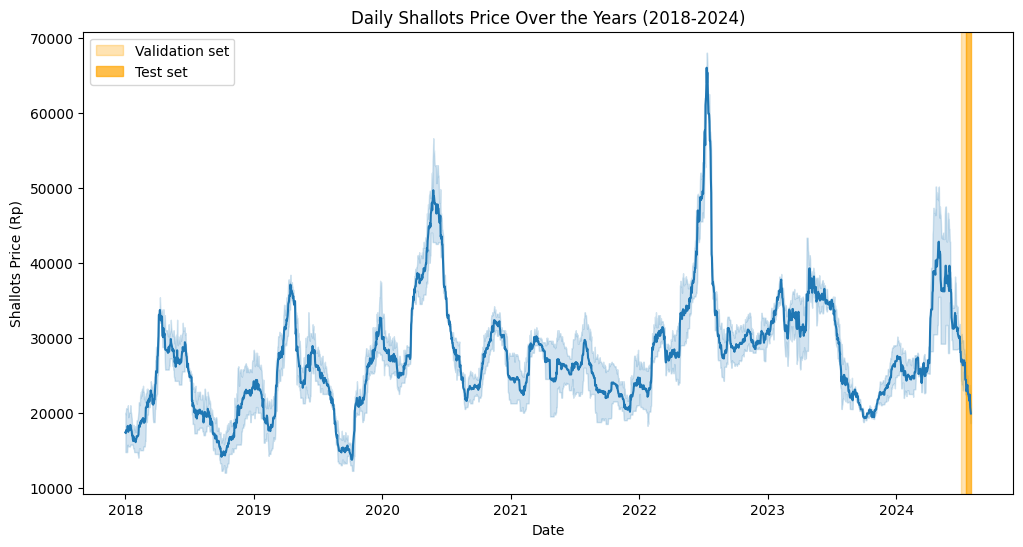

In [11]:
# Plot the daily shallot prices to see the fluctuation and data partition
# to train, val, and test

plt.figure(figsize=(12, 6))
sns.lineplot(prices_df, x="date", y="price")

# Mark the validation timestamp
plt.axvspan(pd.to_datetime(val_start), pd.to_datetime(val_end),
            color="orange", alpha=0.3, label="Validation set")

# Mark the test timestamp
plt.axvspan(pd.to_datetime(test_start), pd.to_datetime(test_end),
            color="orange", alpha=0.7, label="Test set")

plt.xlabel("Date")
plt.ylabel("Shallots Price (Rp)")
plt.title("Daily Shallots Price Over the Years (2018-2024)")
plt.legend()
plt.show()

From the plot above, we can observe that the price trend tends to peak at the beginning of the year and declines in the second half. However, we notice that the seasonal pattern is not very strong in our dataset, especially in the year 2021.

We can see the price distribution for each month throughout the year in the plot below.

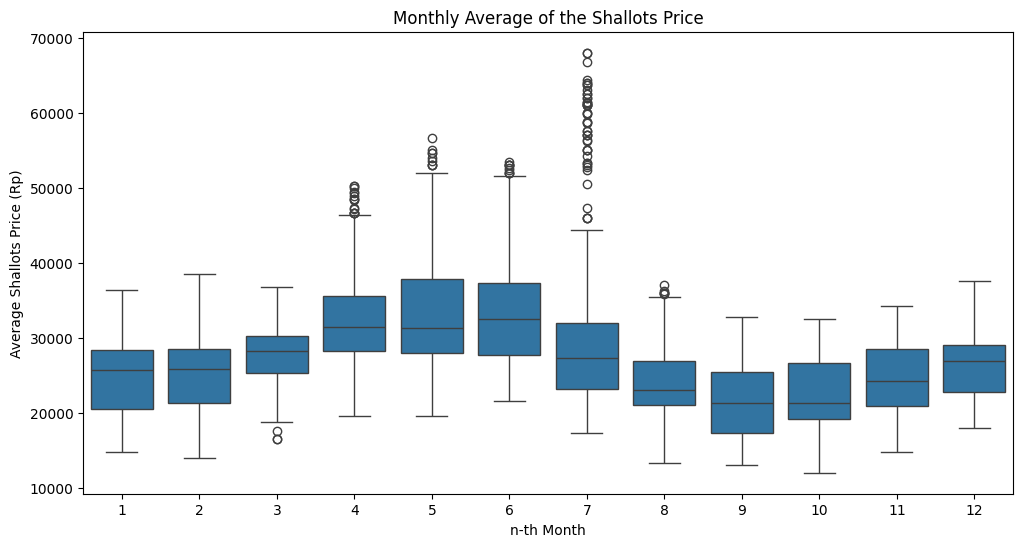

In [12]:
plt.figure(figsize=(12, 6))

sns.boxplot(prices_df, x=prices_df["date"].dt.month, y="price")

plt.xlabel("n-th Month")
plt.ylabel("Average Shallots Price (Rp)")
plt.title("Monthly Average of the Shallots Price")
plt.show()

Then, we can examine the statistics of shallot prices.

In [13]:
prices_df[["regions", "price"]].groupby(["regions"]).agg(
    ["median", "mean", "std", "min", "max"]
)

price                                         
            median          mean          std    min    max
regions                                                    
mojokerto  24250.0  25136.561980  7089.663609  12000  68000
surabaya   29000.0  29622.760399  7465.056849  14600  64400

And, we can also check the prices histogram.

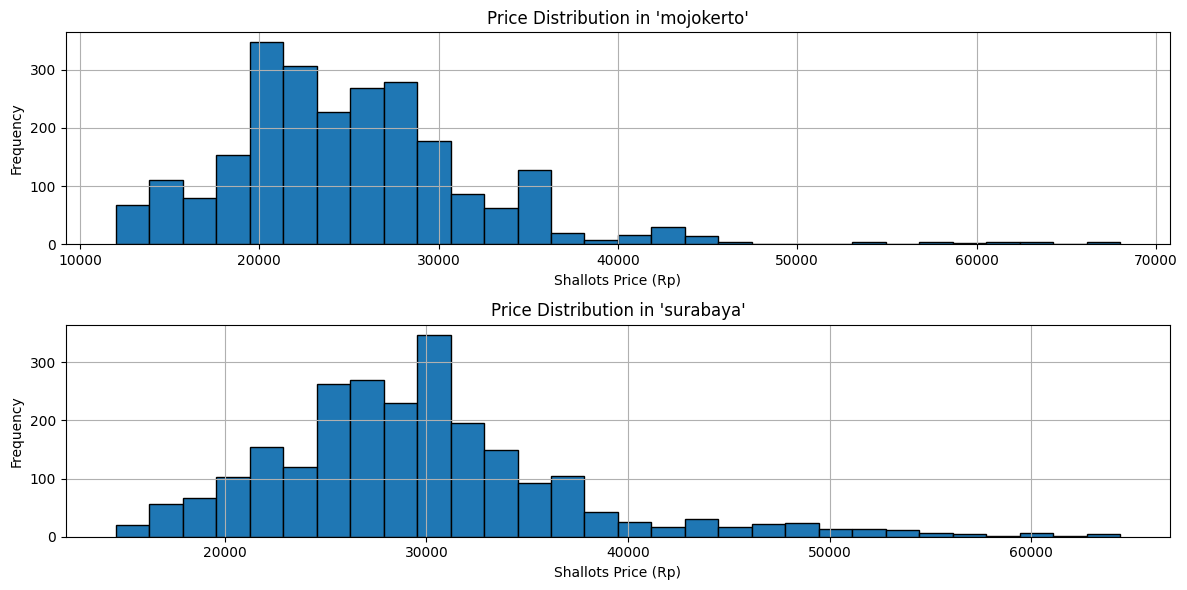

In [14]:
regions = prices_df["regions"].unique()

fig, ax = plt.subplots(len(regions), 1, figsize=(12, 6))
for i, region in enumerate(regions):
    prices_df[prices_df["regions"] == region]["price"].hist(bins=30,
                                                            edgecolor="black",
                                                            ax=ax[i])

    ax[i].set_title(f"Price Distribution in '{region}'")
    ax[i].set_xlabel("Shallots Price (Rp)")
    ax[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

As we can observe from the plots and data statistics, the daily shallot prices fluctuate significantly over time.

# Feature Engineering

---



Now that we have observed price fluctuations, we need to collect additional features to help our model accurately predict future shallot prices in the market.

These additional features include:
- time-related feature,
- holiday-proximity feature, and
- weather feature.

In [15]:
feat_df = prices_df.copy()

## Time-related features

We can add time-related features to capture **seasonality** in our dataset.

Tools like GCP AutoML support the automatic inclusion of date features, while AutoTS requires date features to be added manually. Therefore, we will add multiple time-related features to our dataset.

However, instead of adding straight-forward time features such as day, month, and year, we can encode these features using **sine and cosine transformations**. This approach is commonly used in time series forecasting, as these transformations provide a **continuous representation** of cyclical time patterns.

For a given $t$ time feature that has a $T$ period:

$$ \text{sin_t} = \sin \left( \frac{2 \pi t}{T} \right), $$
$$ \text{cos_t} = \cos \left( \frac{2 \pi t}{T} \right), $$

which in our case, $T$ is equal to 365 (a year) and 180 (6 months).

In [16]:
# Add day of year as a time feature
feat_df["dayofyear"] = feat_df["date"].dt.dayofyear

# Apply sine and cosine transformations with period 365
T = 365
feat_df["featd_dayofyear_sin"] = np.sin(2 * np.pi * feat_df["dayofyear"] / T)
feat_df["featd_dayofyear_cos"] = np.cos(2 * np.pi * feat_df["dayofyear"] / T)

# Apply sine and cosine transformations with period 180
T = 180
feat_df["featd_six-m_sin"] = np.sin(2 * np.pi * feat_df["dayofyear"] / T)
feat_df["featd_six-m_cos"] = np.cos(2 * np.pi * feat_df["dayofyear"] / T)

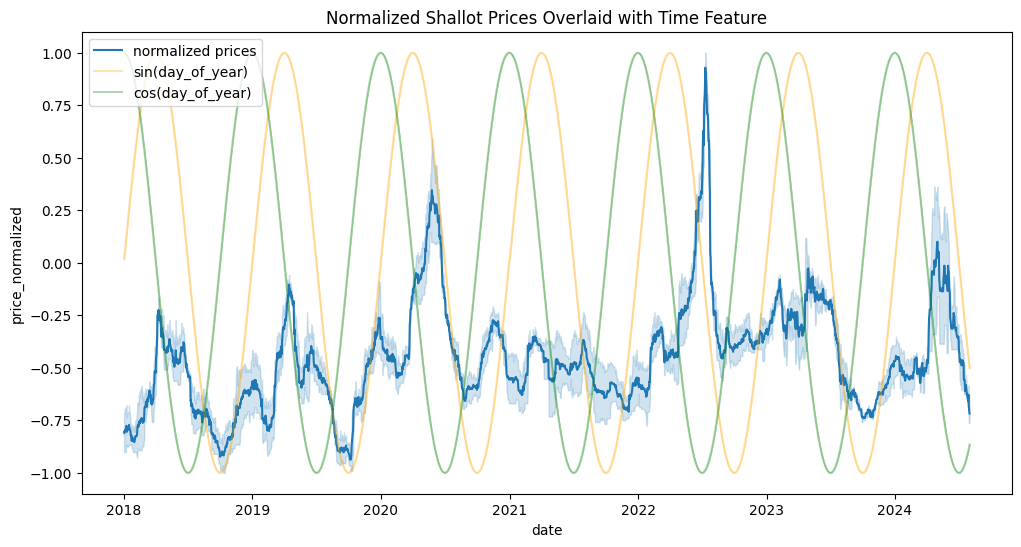

In [17]:
# Plot the time features with the normalized prices
plt.figure(figsize=(12, 6))

# Normalize the prices to (-1, 1) to match the value range of sin(t) and cos(t)
min, max = feat_df["price"].min(), feat_df["price"].max()
feat_df["price_normalized"] = 2 * (feat_df["price"] - min) / (max - min) - 1

# Plot the prices
sns.lineplot(feat_df, x="date", y="price_normalized", label="normalized prices")

# Plot the time features
sns.lineplot(feat_df, x="date", y="featd_dayofyear_sin",
             alpha=0.3, color="orange", label="sin(day_of_year)")
sns.lineplot(feat_df, x="date", y="featd_dayofyear_cos",
             alpha=0.3, color="green", label="cos(day_of_year)")

plt.title("Normalized Shallot Prices Overlaid with Time Feature")
plt.legend(loc="upper left")
plt.show()

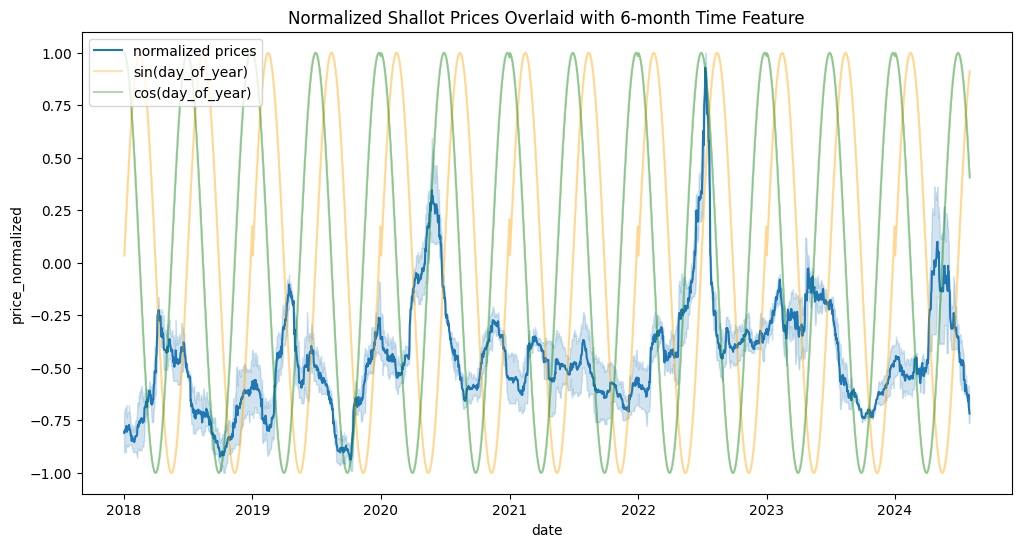

In [18]:
# Plot the time features with the normalized prices
plt.figure(figsize=(12, 6))

# Plot the prices
sns.lineplot(feat_df, x="date", y="price_normalized", label="normalized prices")

# Plot the time features
sns.lineplot(feat_df, x="date", y="featd_six-m_sin",
             alpha=0.3, color="orange", label="sin(day_of_year)")
sns.lineplot(feat_df, x="date", y="featd_six-m_cos",
             alpha=0.3, color="green", label="cos(day_of_year)")

plt.title("Normalized Shallot Prices Overlaid with 6-month Time Feature")
plt.legend(loc="upper left")
plt.show()

We can see from the plot above that our time feature is encoded as intended.

## Holiday-proximity feature

There one more factor that we think can cause fluctuations in commodity prices, which is holidays.

The demand for certain commodities can spike during holiday periods, leading to an increase in prices. For instance, around occasions like Eid al-Fitr, Eid al-Adha, Christmas, and New Year, we often observe a rise in commodity prices.

However, instead of using a binary flag for holidays (like 0 or 1 for one-hot encoding which is available in AutoTS), we decided to add a **holiday proximity feature**, where we encode proximity using a Gaussian function with a **7-day window size**. This allows the proximity value to gradually increase until it peaks on the holiday and then gradually decrease afterward.

The [Gaussian function](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/360px-Normal_Distribution_PDF.svg.png) has a bell-shaped curve and is commonly used to measure the proximity to a specific point. In this problem, it is defined as:

$$f(t_{\pm w}, t) = exp \left( -\frac{\| t_{\pm w}-t \|^2}{2 \sigma^2}  \right),$$

where $t_{\pm w}$ represents the days before or after the holiday, and $t$ is the holiday itself. The $\sigma^2$ is the variance of the Gaussian function, which in this case defined as $\text{window_size}/2$ to make sure that the function taper gradually to zero.

We use the Python library [holidays](https://pypi.org/project/holidays/) to check the holidays.

In [19]:
import holidays

id_holidays = holidays.ID()

In [20]:
# Helper function

def clean_holidays(name):
    """ To make the holidays as 1 and regular days as 0 """

    # Encode None as 'regular day' and exclude the 'second day' holidays
    if not name or "second day" in name.lower():
        return []

    # Replace '(estimated)' and "'"
    name = name.replace("(estimated)", "")
    name = name.replace("'", "")

    # There was a day where several major holidays are happening at once,
    # to handle this, we convert the content to list of holidays
    names = name.lower().strip().split("; ")
    names = ["_".join(n.strip().split()) for n in names]

    return names

def calc_holiday_proximity(df, holiday, window_size=7):
    """ Calculate the proximity to a holiday from current date """

    df = df.copy()

    # Initiate holiday proximity calculation
    df[f"feath_{holiday}"] = 0

    # Get certain holiday dates
    holiday_dates = df.loc[df["holiday_flags"].apply(lambda x: holiday in x),
                           "date"].unique()

    for date in holiday_dates:
        for w_i in range(-window_size, window_size + 1):
            w_date = date + pd.Timedelta(days=w_i)

            if w_date in df["date"].values:
                # Apply Gaussian function
                df.loc[df["date"] == w_date, f"feath_{holiday}"] \
                    += np.exp(-0.5 * (w_i/(window_size/2))**2)

    # Clip the maximum value to 1 in the case of holidays in the close vicinity
    df[f"feath_{holiday}"] = df[f"feath_{holiday}"].clip(upper=1)

    return df

In [21]:
# Get unique holidays
feat_df["holiday_flags"] = feat_df["date"].apply(
                                lambda x: clean_holidays(id_holidays.get(x))
                            )
unique_holidays = list(set(np.hstack(feat_df["holiday_flags"].values)))

In [22]:
# Calculate the holiday proximity feature, we decided to separate the holidays
# into different columns
for holiday in unique_holidays:
    feat_df = calc_holiday_proximity(feat_df, holiday)

<ipython-input-20-ec99768897dc>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.13533528 0.13533528]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["date"] == w_date, f"feath_{holiday}"] \
<ipython-input-20-ec99768897dc>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.13533528 0.13533528]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["date"] == w_date, f"feath_{holiday}"] \
<ipython-input-20-ec99768897dc>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.13533528 0.13533528]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["date"] == w_date, f"feath_{holiday}"] \
<ipython-i

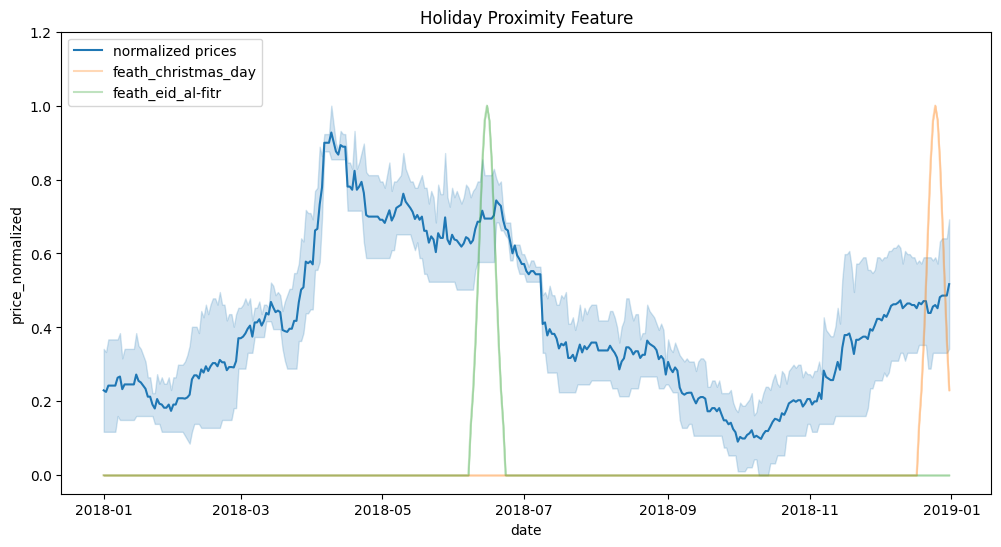

In [23]:
# We can plot some of the holiday proximity feature in the year 2018 for sanity check
plt.figure(figsize=(12, 6))

plot_data = feat_df[feat_df["date"] < "2019"].copy()

# Normalize the prices to (0, 1) to match the value range of holiday proximity
min, max = plot_data["price"].min(), plot_data["price"].max()
plot_data["price_normalized"] = (plot_data["price"] - min) / (max - min)

# Plot the prices
sns.lineplot(plot_data, x="date", y="price_normalized", label="normalized prices")

# Plot the holiday proximity features
for col in feat_df.columns:
    if ("feath" in col) and (col[6:] in ["christmas_day", "eid_al-fitr"]):
        sns.lineplot(plot_data, x="date", y=col,
                    label=col, alpha=0.3)

plt.ylim(top=1.2)
plt.title("Holiday Proximity Feature")
plt.legend(loc="upper left")
plt.show()

As we can see, the holiday proximity feature has been calculated as expected.

## Weather features

An additional feature that could improve our shallot price forecasting model is weather data.

Shallot farming is typically done during the **dry season**, making weather parameters such as average precipitation, daylight duration, and temperature potentially useful in forecasting prices.

However, for simplicity in this project, it is crucial to ensure that these weather parameters are **available during the prediction phase**. Therefore, this project will use the **one-month average of the previous year's weather data** as a feature. This is based on the assumption that last year's weather conditions will be similar to those of the current year.

The weather data is obtained from the free and open-sourced weather API [Open-Meteo](https://open-meteo.com/). We retrieve daily weather data by targeting the locations of several cities across East Java and aggregating the results by calculating the mean value. Hence, the **weather information for both timeseries (Mojokerto and Surabaya city) has the same value**.

In [24]:
# Retrieve the weather data which includes precipitation, daylight duration, and temperature
weather_df = download_csv_from_gcs(bucket, WEATHER_CSV, ["date"])
weather_df.set_index("date", inplace=True)

weather_columns = ["featw_temperature_c", "featw_dayligh_duration_h",
                   "featw_precipitation_sum_mm"]
weather_df.columns = weather_columns

In [25]:
weather_df.head()

,featw_temperature_c,featw_dayligh_duration_h,featw_precipitation_sum_mm
date,,,
2016-01-01,26.84,45205.0,6.58
2016-01-02,26.71,45198.0,5.81
2016-01-03,26.58,45191.0,9.48
2016-01-04,26.29,45183.0,7.10
2016-01-05,26.65,45175.0,2.52


In [26]:
weather_df["month"] = weather_df.index.month
weather_df["year"] = weather_df.index.year

# Calculate the monthly average of the weather condition
monthly_avg_weather = weather_df.groupby(["year", "month"]).mean().round(2)
monthly_avg_weather = monthly_avg_weather.reset_index()

In [27]:
monthly_avg_weather.head()

,year,month,featw_temperature_c,featw_dayligh_duration_h,featw_precipitation_sum_mm
0,2016,1,26.68,45029.48,7.85
1,2016,2,25.97,44449.52,17.58
2,2016,3,26.75,43705.45,9.03
3,2016,4,26.71,42960.70,7.18
4,2016,5,26.97,42360.16,4.27


In [28]:
# Helper function

def get_last_year_weather(row, weather_data):
    """ A function to return the last year month-averaged weather data. """

    month = row["date"].month
    last_year = row["date"].year - 1

    weather_last_year = weather_data[(weather_data["year"] == last_year) &
                                     (weather_data["month"] == month)]

    return weather_last_year.iloc[0]

In [29]:
for col in weather_columns:
    feat_df[col] = feat_df.apply(
                      lambda row: get_last_year_weather(row, monthly_avg_weather)[col],
                      axis=1
                  )

In [30]:
# We also normalize the weather features to (0, 1)
for c in weather_columns:
    min, max = feat_df[c].min(), feat_df[c].max()
    feat_df[c] = (feat_df[c] - min) /  (max - min)

Finally, we can summarize all the additional features that we gather for the shallot prices prediction.

In [31]:
FEAT_COLS = sorted([c for c in feat_df.columns if "feat" in c])

In [32]:
print("Additional features:")
for c in FEAT_COLS: print(f"\t{c}")

Additional features:
	featd_dayofyear_cos
	featd_dayofyear_sin
	featd_six-m_cos
	featd_six-m_sin
	feath_ascension_day
	feath_buddhas_birthday
	feath_christmas_day
	feath_day_of_silence
	feath_eid_al-adha
	feath_eid_al-fitr
	feath_election_day
	feath_good_friday
	feath_independence_day
	feath_international_labor_day
	feath_islamic_new_year
	feath_isra_and_miraj
	feath_lunar_new_year
	feath_new_years_day
	feath_pancasila_day
	feath_prophets_birthday
	featw_dayligh_duration_h
	featw_precipitation_sum_mm
	featw_temperature_c


In [33]:
feat_df = feat_df[["data_split", "date", "regions", "price"] + FEAT_COLS]

In [34]:
feat_df.groupby(["regions", "data_split"]).head(2)

,data_split,date,regions,price,featd_dayofyear_cos,featd_dayofyear_sin,featd_six-m_cos,featd_six-m_sin,feath_ascension_day,feath_buddhas_birthday,...,feath_international_labor_day,feath_islamic_new_year,feath_isra_and_miraj,feath_lunar_new_year,feath_new_years_day,feath_pancasila_day,feath_prophets_birthday,featw_dayligh_duration_h,featw_precipitation_sum_mm,featw_temperature_c
0,TRAIN,2018-01-01,mojokerto,14750,0.999852,0.017213,0.999391,0.034899,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.941306,0.826446,0.159468
1,TRAIN,2018-01-02,mojokerto,14750,0.999407,0.034422,0.997564,0.069756,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.960005,0.0,0.0,0.941306,0.826446,0.159468
2374,VALIDATE,2024-07-02,mojokerto,26500,-0.999667,-0.025818,0.990268,0.139173,0.0,0.0,...,0.0,0.360448,0.0,0.0,0.000000,0.0,0.0,0.043826,0.090909,0.189369
2375,VALIDATE,2024-07-03,mojokerto,24250,-0.999074,-0.043022,0.984808,0.173648,0.0,0.0,...,0.0,0.520450,0.0,0.0,0.000000,0.0,0.0,0.043826,0.090909,0.189369
2389,TEST,2024-07-17,mojokerto,22412,-0.959933,-0.280231,0.788011,0.615661,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.043826,0.090909,0.189369
2390,TEST,2024-07-18,mojokerto,22412,-0.954967,-0.296713,0.766044,0.642788,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.043826,0.090909,0.189369
2404,TRAIN,2018-01-01,surabaya,20000,0.999852,0.017213,0.999391,0.034899,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.941306,0.826446,0.159468
2405,TRAIN,2018-01-02,surabaya,19800,0.999407,0.034422,0.997564,0.069756,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.960005,0.0,0.0,0.941306,0.826446,0.159468
4778,VALIDATE,2024-07-02,surabaya,29666,-0.999667,-0.025818,0.990268,0.139173,0.0,0.0,...,0.0,0.360448,0.0,0.0,0.000000,0.0,0.0,0.043826,0.090909,0.189369
4779,VALIDATE,2024-07-03,surabaya,29333,-0.999074,-0.043022,0.984808,0.173648,0.0,0.0,...,0.0,0.520450,0.0,0.0,0.000000,0.0,0.0,0.043826,0.090909,0.189369


Now we are ready to try AutoML tools!

# AutoTS

---



The first AutoML tools is AutoTS. Its unique features include a flexible model selection process that encompasses a wide range of algorithms, such as ARIMA and advanced deep learning models, along with the use of genetic algorithms for optimizing model and hyperparameter selection. Additionally, AutoTS supports advanced techniques like ensemble methods and quantile forecasting.

In [59]:
from autots import AutoTS, create_regressor
import itertools

IS_AUTOTS_TRAIN = False

We set `prediction_interval=0.90` to enable quantile forecasting. The other parameter like `transformer_list="superfast"` are chosen to speed up training.

In [60]:
# Model hyperparameters
forecast_length = 15 # days
frequency = "D" # for daily
prediction_interval = 0.90
ensemble = ["horizontal-max", "dist", "simple"]
model_list = "fast"
transformer_list = "superfast"
transformer_max_depth = 4 # maximum number of sequential transformers
max_generations = 10
initial_template = "General+Random"
models_to_validate = 0.15
num_validations = 2
validation_method = "backwards" # or similarity
constraint = 2.0 # max(training data) + 2.0 * st.dev(training data)
models_mode = "default"
generation_timeout = 100 # minutes

metric_weighting = {
    'smape_weighting': 2,
    'mae_weighting': 2,
    'rmse_weighting': 1.5,
    'made_weighting': 1,
    'mage_weighting': 0,
    'mate_weighting': 0.01,
    'mle_weighting': 0.1,
    'imle_weighting': 0,
    'spl_weighting': 3,
    'dwae_weighting': 1,
    'uwmse_weighting': 1,
    'dwd_weighting': 0.1,
    "oda_weighting": 0.1,
    'runtime_weighting': 0.05,
}

AutoTS is well integrated with Pandas. However, we need to ensure that the data is in a wide format and indexed by date. The additional features should also be separated, known as the future regressor.

Additionally, note that we are **not using `create_regressor`** provided by AutoTS; instead, we are using our own previously engineered features.

In [61]:
# Prepare training set
train_data = feat_df[feat_df["data_split"].isin(["TRAIN", "VALIDATE"])].copy()
train_data = train_data[["date", "regions", "price"]]
train_data = train_data.pivot(index="date", columns="regions", values="price").reset_index()
train_data.set_index("date", inplace=True)

print(f"Train data size: {train_data.shape}")
print(f"Train data columns: {train_data.columns.values}")
print(f"Train data start: {train_data.index.min().strftime('%Y-%m-%d')}")
print(f"Train data end: {train_data.index.max().strftime('%Y-%m-%d')}")

Train data size: (2389, 2)
Train data columns: ['mojokerto' 'surabaya']
Train data start: 2018-01-01
Train data end: 2024-07-16


In [62]:
unique_region = feat_df["regions"].unique()

In [63]:
validation_indexes = feat_df.loc[feat_df["data_split"] == "VALIDATE", "date"].unique()

In [67]:
# Helper function

def save_or_load_prediction(model_autots, regressor_test, names, IS_AUTOTS_TRAIN=True):
    """ Save prediction to GCS after training or load from GCS if not """

    file_name = f"predictions_autots_{names}_regressor_fast.csv"

    if IS_AUTOTS_TRAIN:
        # Predict prices
        prediction = model_autots.predict(forecast_length=15,
                                          future_regressor=regressor_test)

        # Format the predicted prices from wide to long table merging the regions
        # into one column.
        predictions = prediction.forecast.reset_index()
        predictions = predictions.melt(id_vars="index", value_vars=unique_region,
                                      var_name="regions", value_name="prediction")
        predictions = predictions.rename(columns={"index": "date"})

        # Since we define 'model_list="probabilistic"' and 'prediction_interval=0.90',
        # AutoTS provide `lower_forecast` and `upper_forecast`.
        # The `lower_forecast` in this case corresponds to the prediction at the 5% quantile.
        lower_predictions = prediction.lower_forecast.reset_index()
        lower_predictions = lower_predictions.melt(id_vars="index", value_vars=unique_region,
                                                  var_name="regions", value_name="0.05")
        lower_predictions = lower_predictions.rename(columns={"index": "date"})

        # Meanwhile, the `upper_forecast` in this case corresponds to the prediction
        # at the 95% quantile.
        upper_predictions = prediction.upper_forecast.reset_index()
        upper_predictions = upper_predictions.melt(id_vars="index", value_vars=unique_region,
                                                  var_name="regions", value_name="0.95")
        upper_predictions = upper_predictions.rename(columns={"index": "date"})

        # Merge the point prediction, lower prediction, and upper_prediction
        predictions_autots = pd.merge(predictions,
                                      pd.merge(lower_predictions,
                                              upper_predictions,
                                              on=['date', 'regions']),
                                      on=['date', 'regions'])

        # Save model to GCS
        upload_csv_to_gcs(predictions_autots, bucket, file_name)
    else:
        # Load from GCS if not training the model (for visualization only)
        predictions_autots = download_csv_from_gcs(bucket, file_name)

    return predictions_autots, file_name

We will go ahead and do several trainings using combination of features to see which feature combination results in the best evaluation metrics.

In [68]:
# First, we need a function that can generate features combinations that we want
feature_set = ["date", "holiday", "weather"]

feature_combinations = [()] # for no feature
for s in range(1, len(feature_set) + 1):
    feature_combinations.extend(itertools.combinations(feature_set, s))

feature_combinations

[(),
 ('date',),
 ('holiday',),
 ('weather',),
 ('date', 'holiday'),
 ('date', 'weather'),
 ('holiday', 'weather'),
 ('date', 'holiday', 'weather')]

In [ ]:
# Train the model using combination of features
for i, combination in enumerate(feature_combinations):
    names = '_'.join(combination)
    if not combination:
        names = "no"
    print(f"{i+1}-th training with {names} regressor")

    # Prepare only the features as external regressor for training and testing
    if combination:
        # only get the first char as feature code
        combination = list(c[0] for c in combination)

        COLS = [c for c in FEAT_COLS if c[4] in combination]
        print("\n".join(COLS))

        regressor = feat_df[COLS + ["date", "data_split"]].copy()
        regressor = regressor.drop_duplicates(subset=["date"])
        regressor.set_index("date", inplace=True)

        regressor_train = regressor[regressor["data_split"].isin(["TRAIN", "VALIDATE"])]
        regressor_test = regressor[regressor["data_split"] == "TEST"]

    else:
        # No feature
        regressor_train, regressor_test = None, None

    # --- Model training ---
    model_autots = AutoTS(
        forecast_length=forecast_length,
        frequency=frequency,
        prediction_interval=prediction_interval,
        ensemble=ensemble,
        model_list=model_list,
        transformer_list=transformer_list,
        transformer_max_depth=transformer_max_depth,
        max_generations=max_generations,
        initial_template=initial_template,
        models_to_validate=models_to_validate,
        num_validations=num_validations,
        validation_method=validation_method,
        constraint=constraint,
        models_mode=models_mode,
        generation_timeout=generation_timeout,
        metric_weighting=metric_weighting,
        n_jobs = "auto",
        verbose = 0,
    )
    if IS_AUTOTS_TRAIN:
        model_autots.fit(train_data,
                         future_regressor=regressor_train,
                         validation_indexes=validation_indexes
        )

    names = f"{str(i+1)}_{names}"
    print(names)
    _, _ = save_or_load_prediction(model_autots,
                                   regressor_test,
                                   names,
                                   IS_AUTOTS_TRAIN=IS_AUTOTS_TRAIN)

The output of the above cell is deleted due to its length.

In [ ]:
file_names = !(gsutil ls "gs://{bucket.name}")
file_names = [f for f in file_names if "predictions_autots" in f]

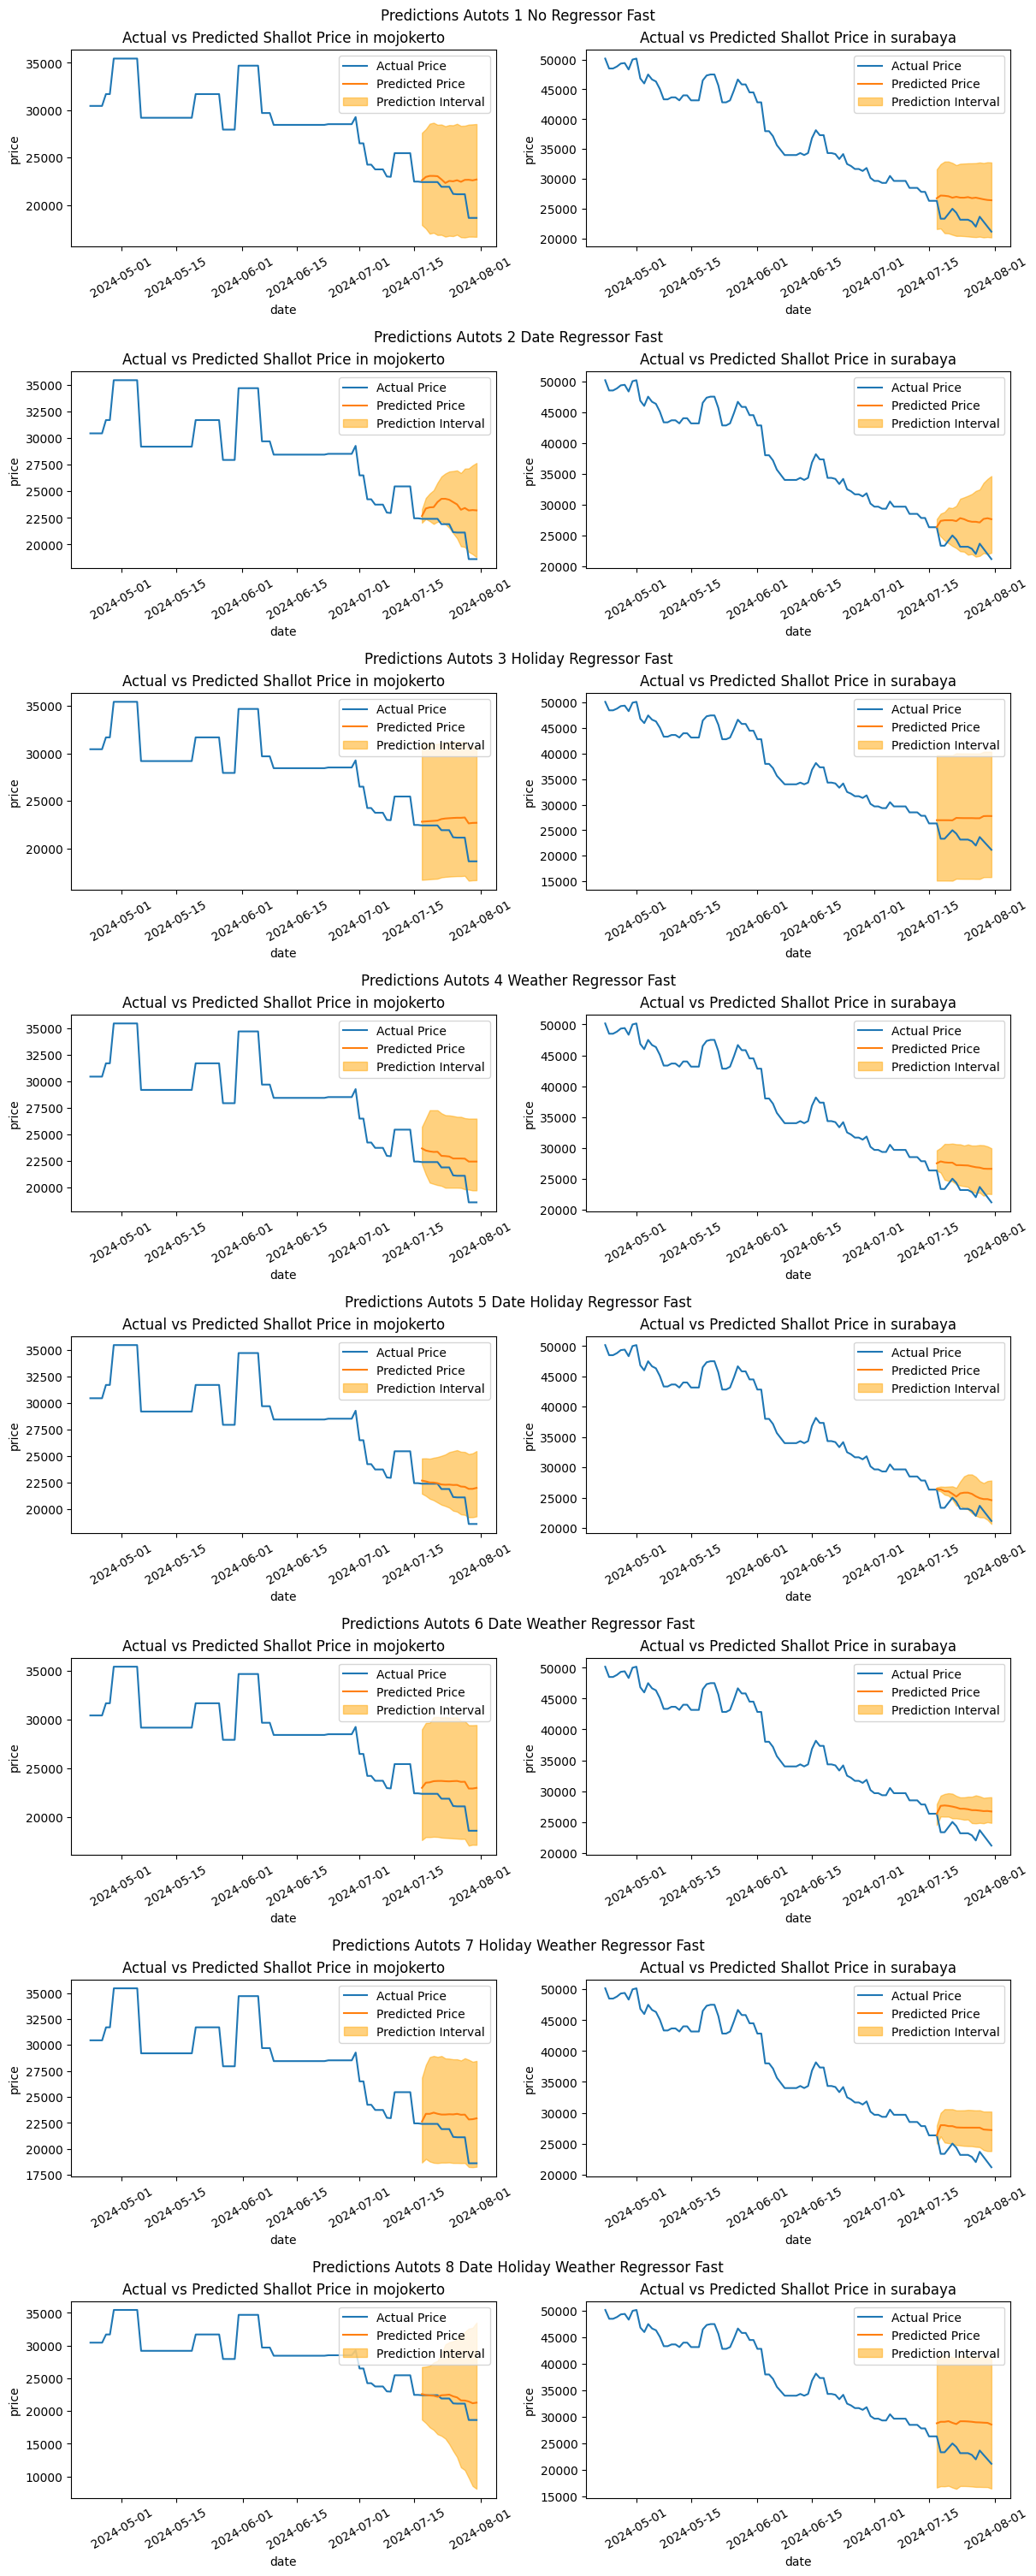

In [56]:
# Plot prediction results
fig = plt.figure(constrained_layout=True, figsize=(12, 30))

subfigs = fig.subfigures(nrows=len(file_names), ncols=1)

for row, subfig in enumerate(subfigs):
    predictions_autots = download_csv_from_gcs(bucket,
                                               os.path.basename(file_names[row]),
                                               date_columns=["date"])
    suptitle = " ".join(os.path.basename(file_names[row][:-4]).split("_")).title()
    subfig.suptitle(suptitle)

    axs = subfig.subplots(nrows=1, ncols=2)
    for col, region in enumerate(unique_region):
        # Only take the last 100 days of data to plot
        actual_price = feat_df[feat_df["regions"] == region].iloc[-100:]

        sns.lineplot(actual_price, x="date", y="price", ax=axs[col], label="Actual Price")

        # Filter predicted prices for each region
        predicted_price = predictions_autots[predictions_autots["regions"] == region]

        sns.lineplot(predicted_price, x="date", y="prediction",
                     ax=axs[col], label="Predicted Price")
        axs[col].fill_between(predicted_price["date"],
                              predicted_price["0.05"],
                              predicted_price["0.95"],
                              color="orange", alpha=0.5,
                              label="Prediction Interval")

        axs[col].set_title(f"Actual vs Predicted Shallot Price in {region}")
        axs[col].legend(loc="upper right")

    # Rotate xticks to improve readability
    for ax in axs:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.xticks(rotation=30)
plt.show()